# 正则化线性回归
这一部分，我们需要先对一个水库的流出水量以及水库水位进行正则化线性归回。然后将会探讨方差-偏差的问题

## 数据可视化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

In [2]:
data = loadmat('ex5data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Nov  4 22:27:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-15.93675813],
        [-29.15297922],
        [ 36.18954863],
        [ 37.49218733],
        [-48.05882945],
        [ -8.94145794],
        [ 15.30779289],
        [-34.70626581],
        [  1.38915437],
        [-44.38375985],
        [  7.01350208],
        [ 22.76274892]]),
 'y': array([[ 2.13431051],
        [ 1.17325668],
        [34.35910918],
        [36.83795516],
        [ 2.80896507],
        [ 2.12107248],
        [14.71026831],
        [ 2.61418439],
        [ 3.74017167],
        [ 3.73169131],
        [ 7.62765885],
        [22.7524283 ]]),
 'Xtest': array([[-33.31800399],
        [-37.91216403],
        [-51.20693795],
        [ -6.13259585],
        [ 21.26118327],
        [-40.31952949],
        [-14.54153167],
        [ 32.55976024],
        [ 13.39343255],
        [ 44.20988595],
        [ -1.14267768],
        [-

In [3]:
X_raw = data['X']
y_raw = data['y']

Xtest_raw = data['Xtest']
ytest = data['ytest']

Xval_raw = data['Xval']
yval = data['yval'] 

In [4]:
X_raw.shape, y_raw.shape, yval.shape

((12, 1), (12, 1), (21, 1))

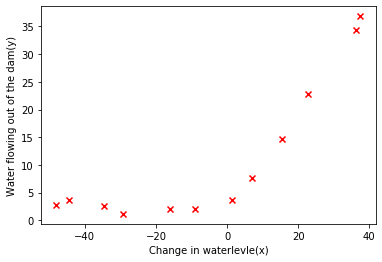

In [5]:
# 绘图
plt.scatter(X_raw, y_raw, c='r', marker='x')
plt.xlabel('Change in waterlevle(x)')
plt.ylabel('Water flowing out of the dam(y)')
plt.show()

In [6]:
# 初始化
X = np.insert(X_raw, 0, np.ones(len(X_raw)), axis=1)
Xval = np.insert(Xval_raw, 0, np.ones(len(Xval_raw)), axis=1)
y = y_raw
theta = np.ones(X.shape[1])

In [7]:
X.shape, y.shape, theta.shape

((12, 2), (12, 1), (2,))

In [8]:
theta

array([1., 1.])

In [9]:
theta[1:]

array([1.])

## 正则化线性回归代价函数
**公式：**![](https://img.arctee.cn/202121240651-q.png)

In [10]:
# 代价函数
def cost(theta, X, y):
    theta = theta.reshape(1, X.shape[1])
    inner = np.power(X @ theta.T - y, 2)
    return 1 / (2*len(X)) * np.sum(inner)

In [11]:
# 正则化代价函数
def costReg(theta, X, y, lam):
    #theta = theta.reshape(1, 2)
    first = cost(theta, X, y)
    reg = lam / (2*len(X)) * np.sum((np.power(theta[1:], 2)))
    return first + reg

In [12]:
cost(theta, X, y)

303.9515255535976

In [13]:
costReg(theta, X, y, lam=1)

303.9931922202643

## 正则化梯度函数
**公式：**![](https://img.arctee.cn/202121240702-m.png)

In [14]:
# 梯度函数
def gradient(theta, X, y):
    theta = theta.reshape(1, X.shape[1])
    inner = (X @ theta.T - y).T @ X
    return 1 / len(X) * inner

In [15]:
# 正则化梯度函数
def gradientReg(theta, X, y, lam):
    theta = theta.reshape(1, X.shape[1])
    theta_reg = theta.copy() # 不能直接将theta第一项置为0
    first = gradient(theta, X, y)
    theta_reg[0, 0] = 0
    reg = lam / len(X) * theta_reg
    return first + reg

In [16]:
gradient(theta, X, y)

array([[-15.30301567, 598.16741084]])

In [17]:
gradientReg(theta, X, y, lam=1)

array([[-15.30301567, 598.25074417]])

## 训练模型

In [18]:
import scipy.optimize as opt
lam = 0 # 因为我们现在训练的是2维的，所以正则化不会对这种低维的有很大的帮助。
res = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(X, y, lam))
res[0]

array([13.08790378,  0.36777923])

## 画出决策曲线

In [19]:
res[0]

array([13.08790378,  0.36777923])

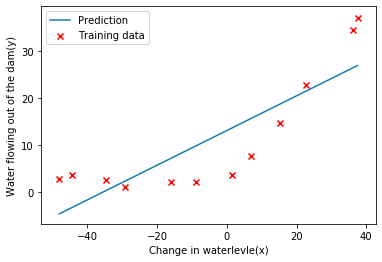

In [20]:
x = np.linspace(X.min(), X.max(), 100)
t = res[0][0] + res[0][1] * x

plt.plot(x, t, label = 'Prediction')
plt.scatter(X_raw, y_raw, c='r', marker='x', label='Training data')
plt.xlabel('Change in waterlevle(x)')
plt.ylabel('Water flowing out of the dam(y)')
plt.legend()
plt.show()

# 偏差和方差 Bias-variance
机器学习中的一个重要概念是偏差-方差权衡。偏差较大的模型会欠拟合，而方差较大的模型会过拟合。这部分会让你画出学习曲线来判断方差和偏差的问题。

## 学习曲线
1.使用训练集的子集来拟合应模型  
2.在计算训练代价和验证集代价时，没有用正则化  
3.记住使用相同的训练集子集来计算训练代价  

In [21]:
def learningCurve(X, y, Xval, yval, lam=0):
    J_train = np.ones(len(X))
    J_val = np.ones(len(X))
    for i in range(len(X)):
        # 依次增加训练集数据
        training_X = X[: i+1, :]
        training_y = y[: i+1, :]
        theta = np.ones(X.shape[1])
        
        res = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(training_X, training_y, lam))
        J_train[i] = costReg(res[0], training_X, training_y, lam)
        J_val[i] = costReg(res[0], Xval, yval, lam)
        if i == (len(X) -1):
            final_theta = res[0]
    return J_train, J_val, final_theta

In [22]:
learningCurve(X, y, Xval, yval, lam=0)

(array([8.63153419e-18, 8.37104465e-18, 3.28659505e+00, 2.84267769e+00,
        1.31540488e+01, 1.94439625e+01, 2.00985217e+01, 1.81728587e+01,
        2.26094054e+01, 2.32614616e+01, 2.43172496e+01, 2.23739065e+01]),
 array([169.87070841, 110.30036585,  45.01023123,  48.36891147,
         35.86516421,  33.82996175,  31.97098573,  30.86244629,
         31.13599793,  28.93620722,  29.55143198,  29.4338178 ]),
 array([13.08790378,  0.36777923]))

In [23]:
X

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

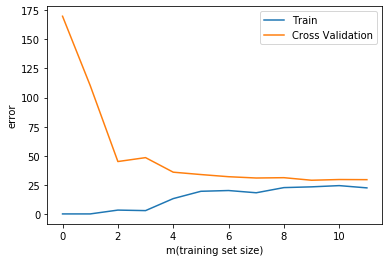

In [24]:
x = np.arange(len(X))
t1, t2, final_theta = learningCurve(X, y, Xval, yval, lam=0)

plt.plot(x, t1, label = 'Train')
plt.plot(x, t2, label = 'Cross Validation')

plt.xlabel('m(training set size)')
plt.ylabel('error')
plt.legend()
plt.show()

从学习曲线上可以得到，这一个高偏差的模型（欠拟合），随着数据的增多训练集和验证集的误差都很高且接近。

# 多项式回归 Polynomial regression
线性回归对于现有数据来说太简单了，会欠拟合，我们需要多添加一些特征。
写一个函数，输入原始X，和幂的次数p，返回X的1到p次幂
![](https://img.arctee.cn/202121240926-p.png)

## 特征映射

In [25]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{0}'.format(p): np.power(x, p) for p in range(1, power+1)}
    df = pd.DataFrame(data)

    return df.values if as_ndarray else df

In [26]:
data = loadmat('ex5data1.mat')  # 将二维变为一维后才能化为 DataFrame 结构  
X, Xval, Xtest = map(np.ravel,[data['X'], data['Xval'], data['Xtest']]) ## 利用ravel函数

y = data['y']

ytest = data['ytest']

yval = data['yval'] 

In [27]:
X

array([-15.93675813, -29.15297922,  36.18954863,  37.49218733,
       -48.05882945,  -8.94145794,  15.30779289, -34.70626581,
         1.38915437, -44.38375985,   7.01350208,  22.76274892])

In [28]:
X_raw

array([[-15.93675813],
       [-29.15297922],
       [ 36.18954863],
       [ 37.49218733],
       [-48.05882945],
       [ -8.94145794],
       [ 15.30779289],
       [-34.70626581],
       [  1.38915437],
       [-44.38375985],
       [  7.01350208],
       [ 22.76274892]])

In [29]:
y.shape

(12, 1)

In [30]:
df = poly_features(X, power=3)
df

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


## 特征归一化

In [31]:
def normalize_feature(df):
    return (df - df.mean()) / df.std()

In [32]:
normalize_feature(df)

,f1,f2,f3
0,-0.362141,-0.755087,0.182226
1,-0.803205,0.001258,-0.247937
2,1.377467,0.584827,1.249769
3,1.420940,0.706647,1.359846
4,-1.434149,1.854000,-2.037163
5,-0.128687,-0.975969,0.251385
6,0.680582,-0.780029,0.340656
7,-0.988534,0.451358,-0.601282
8,0.216076,-1.074993,0.266275
9,-1.311501,1.422806,-1.548121


## 准备数据

In [33]:
def prepare_poly_data(x, power, as_ndarray=False):
    df = poly_features(x, power, as_ndarray)
    df_nor = normalize_feature(df)
    df_nor.insert(0, 'ones', 1)
    return df_nor.values

In [34]:
df = prepare_poly_data(X, power=8, as_ndarray=False)
df

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01],
       [ 1.00000000e+00,  1.42093988e+00,  7.06646754e-01,
         1.35984559e+00,  3.95534038e-01,  1.10616178e+00,
         1.25637135e-01,  8.71929081e-01, -5.96376930e-02],
       [ 1.00000000e+00, -1.43414853e+00,  1.85399982e+00,
        -2.03716308e+00,  2.33143133e+00, -2.41153626e+00,
         2.60221195e+00, -2.64567451e+00,  2.76608525e+00],
       [ 1.00000000e+00, -1.28687086e-01, -9.75968776e-01,
         2.51385075e-01, -7.39686869e-01,  3.169529

## 绘制学习曲线及决策曲线

In [35]:
def plot_learning_curve(X, y, Xval, yval, lam=0):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    
    # 学习曲线
    df_train = prepare_poly_data(X, power=8, as_ndarray=False)
    df_val = prepare_poly_data(Xval, power=8, as_ndarray=False)
    
    x1 = np.arange(len(X))
    t1, t2, final_theta = learningCurve(df_train, y, df_val, yval, lam)

    ax[0].plot(x, t1, label = 'Train')
    ax[0].plot(x, t2, label = 'Cross Validation')

    ax[0].set_xlabel('m(training set size)')
    ax[0].set_ylabel('error')
    ax[0].legend()
    
    # 决策曲线       
    x2 = np.linspace(X.min(), X.max(), 100)
    x_map = prepare_poly_data(x2, power=8, as_ndarray=False)
    h = x_map @ final_theta.T
    ax[1].plot(x2, h, c='b', label='Prediction')
    ax[1].scatter(X_raw, y_raw, c='r', marker='x', label='Training Data')
    
    ax[1].set_xlabel('Change in waterlevle(x)')
    ax[1].set_ylabel('Water flowing out of the dam(y)')
    ax[1].legend()
    
    plt.show()

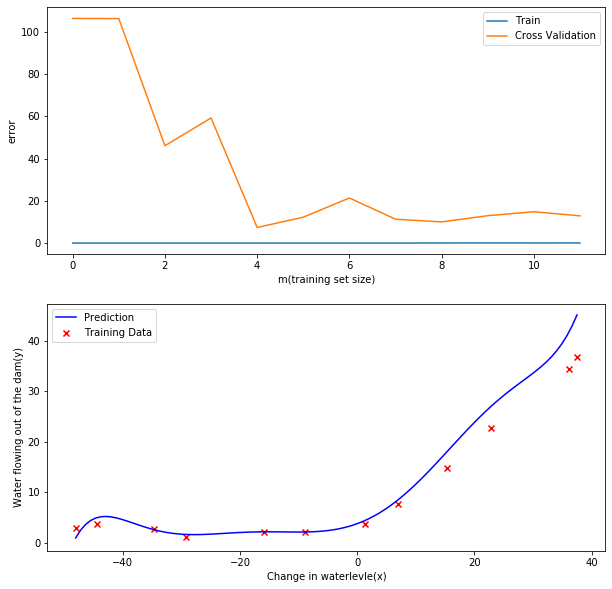

In [36]:
plot_learning_curve(X, y, Xval, yval, lam=0)

你可以看到训练的代价太低了，不真实. 这是 过拟合了

## 调整正则化系数λ

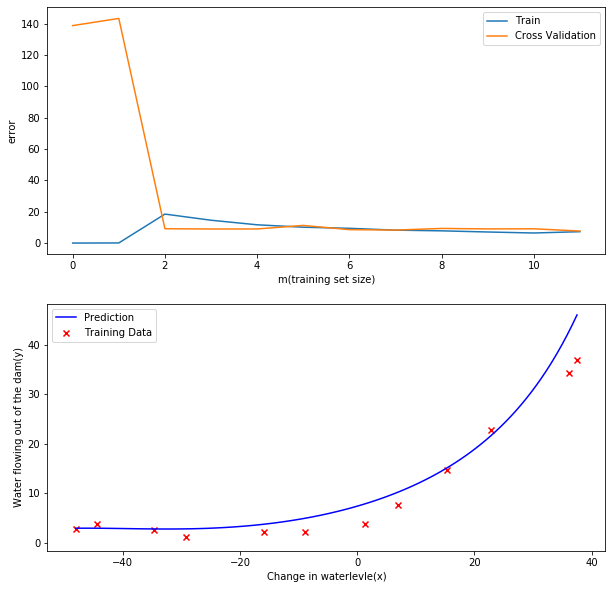

In [37]:
# λ=1
plot_learning_curve(X, y, Xval, yval, lam=1)

训练代价不再是0了，也就是说我们减轻过拟合

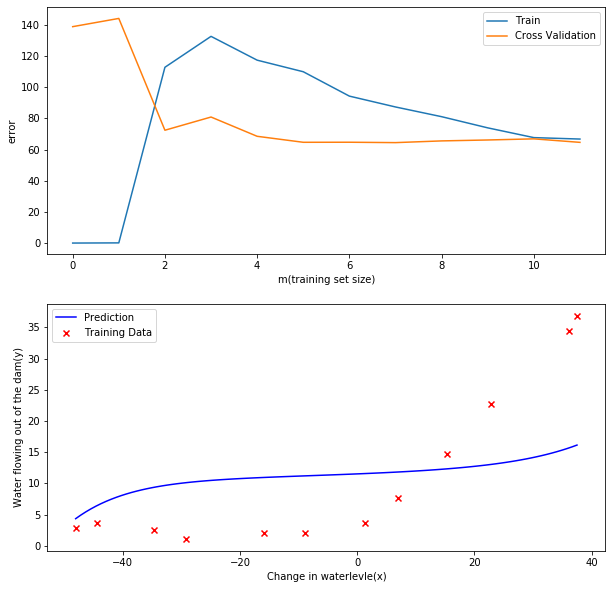

In [38]:
# λ=100
plot_learning_curve(X, y, Xval, yval, lam=100)

太多正则化惩罚太多，变成 欠拟合状态

## 找到最佳的λ
通过之前的实验，我们可以发现λ可以极大程度地影响正则化多项式回归。  
所以这部分我们会使用验证集去评价模型的表现好坏，然后选择表现最好的λ，再用测试集测试模型在没有出现过的数据上的表现。  
尝试值[0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]  

In [39]:
candidate_lam = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

In [40]:
len(candidate_lam)

10

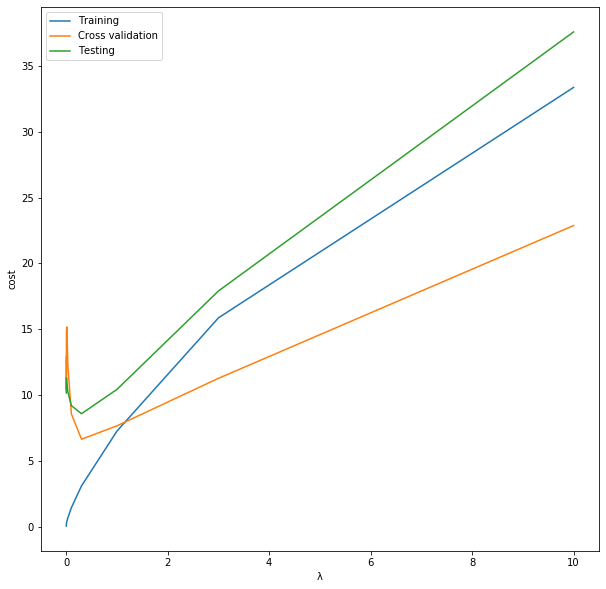

In [41]:
df_train = prepare_poly_data(X, power=8, as_ndarray=False)
df_val = prepare_poly_data(Xval, power=8, as_ndarray=False)
df_test = prepare_poly_data(Xtest, power=8, as_ndarray=False)

theta = np.ones(df_train.shape[1])

num = len(candidate_lam)

training_cost, cv_cost, test_cost = [], [], []

for lam in candidate_lam:
    res = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(df_train, y, lam))
    tc = costReg(res[0], df_train, y, lam)
    cv = costReg(res[0], df_val, yval, lam)
    test_c = costReg(res[0], df_test, ytest, lam)
    
    training_cost.append(tc)
    cv_cost.append(cv)
    test_cost.append(test_c)

plt.figure(figsize=(10, 10))
plt.plot(candidate_lam, training_cost, label='Training')
plt.plot(candidate_lam, cv_cost, label='Cross validation')
plt.plot(candidate_lam, test_cost, label='Testing')

plt.xlabel('λ')
plt.ylabel('cost')
plt.legend()
plt.show()

In [42]:
# 从验证集中找，最优的lambda=1
candidate_lam[np.argmin(cv_cost)]

0.3

In [43]:
# 从测试集中找，最优的lambda=0.3
candidate_lam[np.argmin(test_cost)]

0.3